# Explore here

In [ ]:
import pandas as pd

# Carga del conjunto de datos
def load_data(url):
    # Seleccionamos las columnas
    columns = ["MedInc", "Latitude", "Longitude"]
    df = pd.read_csv(url)[columns]
    return df

# Cargar los datos
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
df = load_data(url)
print(df.head())


   MedInc  Latitude  Longitude
0  8.3252     37.88    -122.23
1  8.3014     37.86    -122.22
2  7.2574     37.85    -122.24
3  5.6431     37.85    -122.25
4  3.8462     37.85    -122.25


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalización de los datos
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return normalized, scaler

# Normalizar los datos
df_normalized, scaler = normalize_data(df)
print(df_normalized.head())


     MedInc  Latitude  Longitude
0  0.539668  0.567481   0.211155
1  0.538027  0.565356   0.212151
2  0.466028  0.564293   0.210159
3  0.354699  0.564293   0.209163
4  0.230776  0.564293   0.209163


# División de datos

In [ ]:
from sklearn.model_selection import train_test_split

# División de los datos en conjunto de entrenamiento y prueba
def split_data(X, test_size=0.2, random_state=33):
    return train_test_split(X, test_size=test_size, random_state=random_state)

# Dividir los datos
X_train, X_test = split_data(df_normalized)
print("Entrenamiento:", X_train.shape)
print("Prueba:", X_test.shape)


Entrenamiento: (16512, 3)
Prueba: (4128, 3)


In [ ]:
from sklearn.cluster import KMeans

# K-Means clustering
def perform_kmeans(X_train, n_clusters=6, random_state=33):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X_train)
    return kmeans, kmeans.labels_

# Entrenamiento del modelo K-Means
kmeans, cluster_labels_train = perform_kmeans(X_train)
X_train['clusters'] = cluster_labels_train


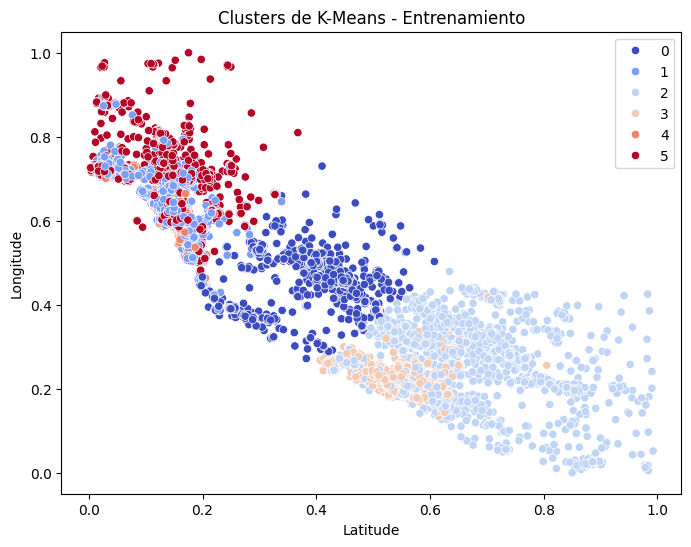

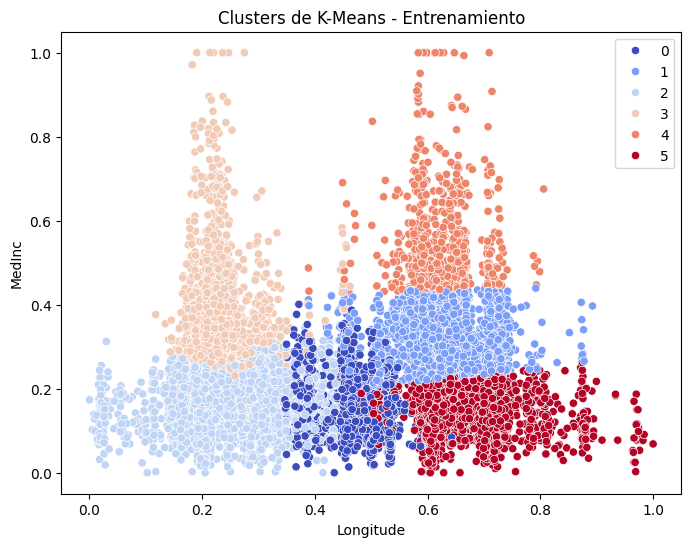

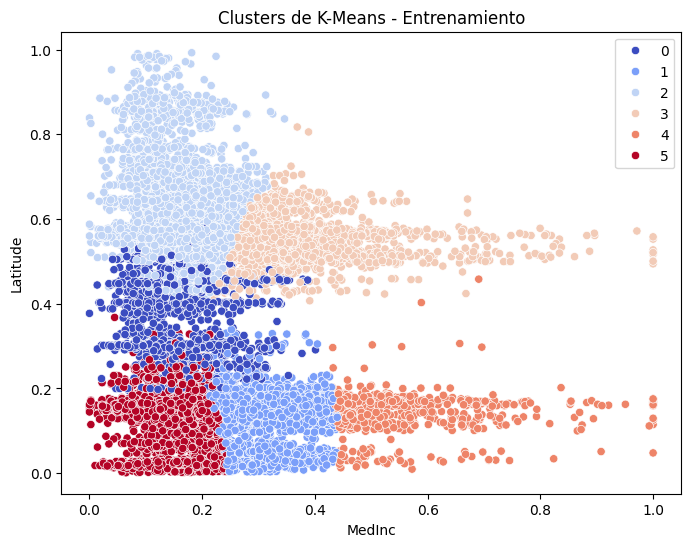

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para graficar los resultados
def plot_clusters(X, labels, title, x_col, y_col):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=X, x=x_col, y=y_col, hue=labels, palette="coolwarm")
    plt.title(title)
    plt.show()

# Graficar los clusters
plot_clusters(X_train, cluster_labels_train, "Clusters de K-Means - Entrenamiento", "Latitude", "Longitude")
plot_clusters(X_train, cluster_labels_train, "Clusters de K-Means - Entrenamiento", "Longitude", "MedInc")
plot_clusters(X_train, cluster_labels_train, "Clusters de K-Means - Entrenamiento", "MedInc", "Latitude")


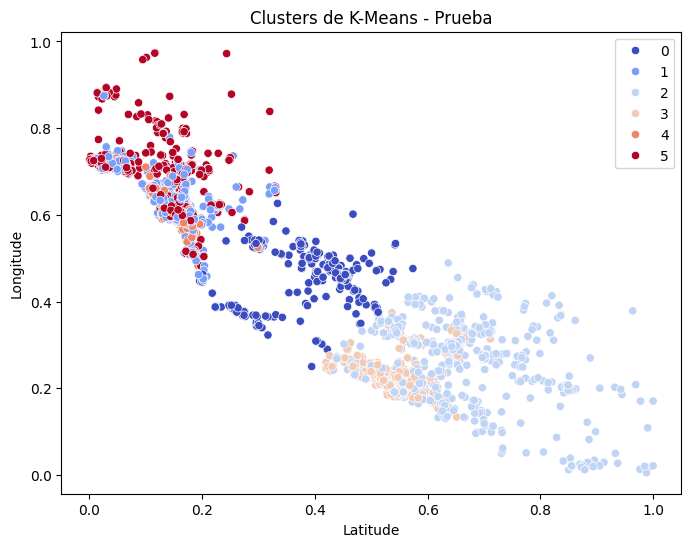

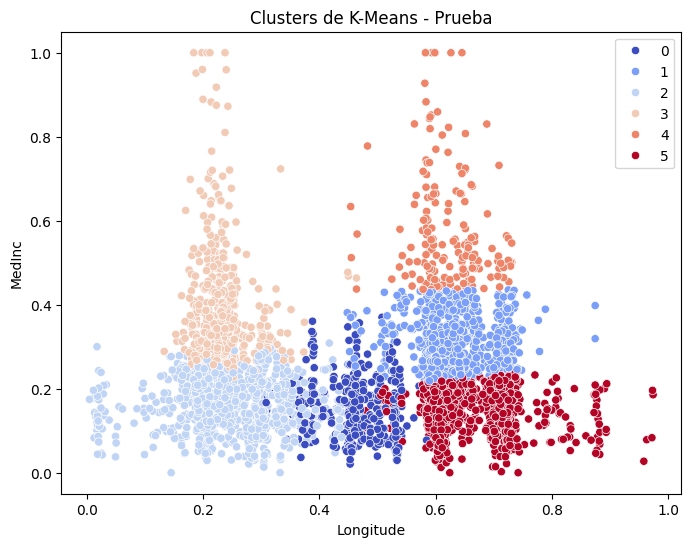

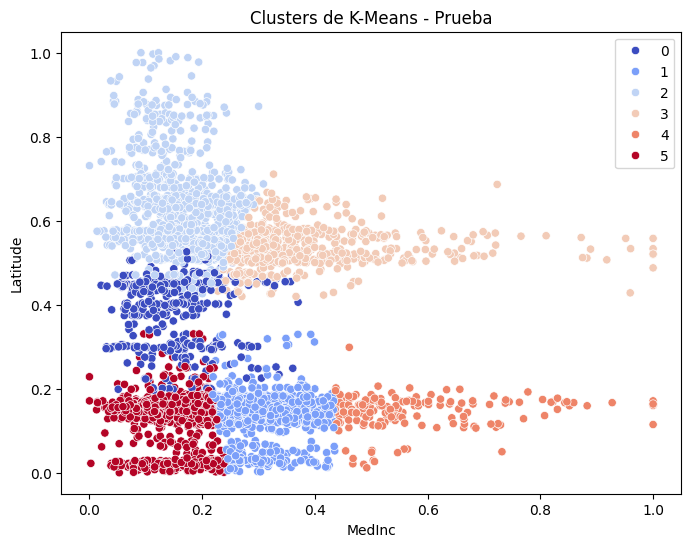

In [7]:
# Predicción con el conjunto de test
cluster_labels_test = kmeans.predict(X_test)
X_test['clusters'] = cluster_labels_test

# Graficar los clusters en el conjunto de prueba
plot_clusters(X_test, cluster_labels_test, "Clusters de K-Means - Prueba", "Latitude", "Longitude")
plot_clusters(X_test, cluster_labels_test, "Clusters de K-Means - Prueba", "Longitude", "MedInc")
plot_clusters(X_test, cluster_labels_test, "Clusters de K-Means - Prueba", "MedInc", "Latitude")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Entrenamiento de Random Forest
def train_random_forest(X_train, y_train, X_test, y_test):
    # Definir el espacio de búsqueda de hiperparámetros
    param_dist = {
        'n_estimators': np.arange(50, 500, 50),
        'max_depth': np.arange(10, 100, 10),
        'min_samples_split': np.arange(2, 10, 1),
        'min_samples_leaf': np.arange(1, 10, 1),
        'max_features': ['sqrt', 'log2', None]
    }

    rf = RandomForestClassifier(random_state=33)
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=33)
    random_search.fit(X_train, y_train)

    # Mejor modelo y evaluación
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Mejores hiperparámetros: {random_search.best_params_}")
    print(f"Precisión del modelo: {accuracy}")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    return best_model

# Entrenamiento del modelo de Random Forest
best_rf_model = train_random_forest(X_train, X_train['clusters'], X_test, X_test['clusters'])


Mejores hiperparámetros: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(4), 'max_features': None, 'max_depth': np.int64(10)}
Precisión del modelo: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       1.00      1.00      1.00       860
           2       1.00      1.00      1.00      1031
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       175
           5       1.00      1.00      1.00      1175

    accuracy                           1.00      4128
   macro avg       1.00      1.00      1.00      4128
weighted avg       1.00      1.00      1.00      4128



In [12]:
from sklearn.metrics import accuracy_score, classification_report
import pickle
import os

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar los resultados de las métricas de prueba
def save_test_results(y_test, y_pred, filename):
    ensure_dir(os.path.dirname(filename))  
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Guardar los resultados en un archivo
    results = {
        'accuracy': accuracy,
        'classification_report': report
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(results, f)


# Entrenamos el modelo
best_rf_model = train_random_forest(X_train, X_train['clusters'], X_test, X_test['clusters'])

# Realizamos las predicciones
y_pred = best_rf_model.predict(X_test)

# Guardamos las métricas
save_test_results(X_test['clusters'], y_pred, 'models/random_forest_test_results.pkl')

print(f"Precisión del modelo: {accuracy_score(X_test['clusters'], y_pred)}")
print("Reporte de clasificación:")
print(classification_report(X_test['clusters'], y_pred))


Mejores hiperparámetros: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(4), 'max_features': None, 'max_depth': np.int64(10)}
Precisión del modelo: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       1.00      1.00      1.00       860
           2       1.00      1.00      1.00      1031
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       175
           5       1.00      1.00      1.00      1175

    accuracy                           1.00      4128
   macro avg       1.00      1.00      1.00      4128
weighted avg       1.00      1.00      1.00      4128

Precisión del modelo: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       1.00      1.00      1.00       860
           2     

In [11]:
import os
import pickle

# Crear directorio 
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar el modelo entrenado
def save_model(model, filename):
    ensure_dir(os.path.dirname(filename))  # Aseguramos que el directorio exista
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Guardar los modelos entrenados
save_model(kmeans, 'models/kmeans_model.pkl')
save_model(best_rf_model, 'models/random_forest_model.pkl')

